# Instance Segmentation

In this tutorial, you will learn:
- the basic structure of Mask R-CNN.
- to perform inference with a MMDetection detector.
- to train a new instance segmentation model with a new dataset.

Let's start!

<a href="https://colab.research.google.com/drive/11MqMCyF_V7Rkw6b9CCShGfNTP59OJ905?usp=sharing"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"></a>

If you are running the tutorial files on the colab platform or a new virtual environment, please run the following code first to configure the runtime environment.
```python
!pip install -U openmim
!mim install "mmengine>=0.7.0"
!mim install "mmcv>=2.0.0rc4"

# Install mmdetection
!rm -rf mmdetection
!git clone https://github.com/open-mmlab/mmdetection.git
%cd mmdetection

!pip install -e .
```

In [2]:
# !pip install -U openmim

In [3]:
# !mim install mmcv

In [1]:
import os
import numpy as np
import mmcv
import matplotlib.pyplot as plt
import mmengine
import pandas as pd
from pprint import pprint

In [ ]:
# from google.colab import files
# files.upload()

In [ ]:
# ! mkdir ~/.kaggle
# ! cp /content/drive/MyDrive/Project/kaggle.json ~/.kaggle/
# ! chmod 600 ~/.kaggle/kaggle.json
# ! kaggle datasets list

In [ ]:
# os.chdir('/content/drive/MyDrive/Project/mmdetection')
# os.chdir('/content/drive/MyDrive/COMP4471/Project/mmdetection')


In [ ]:
# ! kaggle competitions download -c imaterialist-fashion-2019-FGVC6

In [5]:
# Check Pytorch installation
import torch, torchvision
print("torch version:",torch.__version__, "cuda:",torch.cuda.is_available())

# Check MMDetection installation
import mmdet
print("mmdetection:",mmdet.__version__)

# Check mmcv installation
import mmcv
print("mmcv:",mmcv.__version__)

# Check mmengine installation
import mmengine
print("mmengine:",mmengine.__version__)


torch version: 2.0.0 cuda: False
mmdetection: 3.2.0
mmcv: 2.1.0
mmengine: 0.9.1


## Perform Inference with An MMDetection Detector

### A two-stage detector

In this tutorial, we use Mask R-CNN, a simple two-stage detector as an example.

The high-level architecture of Mask R-CNN is shown in the following picture. More details can be found in the [paper](https://arxiv.org/abs/1703.06870).

<img src="https://user-images.githubusercontent.com/40661020/143967081-c2552bed-9af2-46c4-ae44-5b3b74e5679f.png" alt="mask rcnn" align="bottom" />

Mask R-CNN adds a mask branch based on the original Faster R-CNN. It also uses RoIAlign, a more precise version of RoIPooling for RoI feature extraction to improve the performance.





In [ ]:
!mim download mmdet --config mask-rcnn_r50-caffe_fpn_ms-poly-3x_coco --dest ./checkpoints

processing mask-rcnn_r50-caffe_fpn_ms-poly-3x_coco...
downloading ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.6/169.6 MiB 12.1 MB/s eta 0:00:00
Successfully downloaded mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth to /content/mmdetection/checkpoints
Successfully dumped mask-rcnn_r50-caffe_fpn_ms-poly-3x_coco.py to /content/mmdetection/checkpoints


In [ ]:
import mmcv
import mmengine
from mmdet.apis import init_detector, inference_detector
from mmdet.utils import register_all_modules
# Choose to use a config and initialize the detector
config_file = 'configs/mask_rcnn/mask-rcnn_r50-caffe_fpn_ms-poly-3x_coco.py'
# Setup a checkpoint file to load
checkpoint_file = 'checkpoints/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth'

# register all modules in mmdet into the registries
register_all_modules()

# build the model from a config file and a checkpoint file
model = init_detector(config_file, checkpoint_file, device='cuda:0')  # or device='cuda:0'


Loads checkpoint by local backend from path: checkpoints/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth


From the printed model, we will find that the model does consist of the components that we described earlier. It uses ResNet as its CNN backbone, and has a RPN head and RoI Head.
The RoI Head includes box head and mask head. In addition, the model has a neural network module, named neck, directly after the CNN backbone. It is a [feature pyramid network (FPN)](https://arxiv.org/abs/1612.03144) for enhancing the multi-scale features.


### Inference with the detector

The model is successfully created and loaded, let's see how good it is. We use the high-level API `inference_detector` implemented in the MMDetection. This API is created to ease the inference process. The details of the codes can be found [here](https://github.com/open-mmlab/mmdetection/blob/master/mmdet/apis/inference.py#L15).

In [ ]:
# Use the detector to do inference
image = mmcv.imread('demo/demo.jpg',channel_order='rgb')
result = inference_detector(model, image)
print(result)

<DetDataSample(

    META INFORMATION
    img_path: None
    batch_input_shape: (800, 1216)
    ori_shape: (427, 640)
    img_id: 0
    scale_factor: (1.8734375, 1.873536299765808)
    img_shape: (800, 1199)
    pad_shape: (800, 1216)

    DATA FIELDS
    ignored_instances: <InstanceData(
        
            META INFORMATION
        
            DATA FIELDS
            labels: tensor([], device='cuda:0', dtype=torch.int64)
            masks: BitmapMasks(num_masks=0, height=427, width=640)
            bboxes: tensor([], device='cuda:0', size=(0, 4))
        ) at 0x7bc5766366e0>
    gt_instances: <InstanceData(
        
            META INFORMATION
        
            DATA FIELDS
            labels: tensor([], device='cuda:0', dtype=torch.int64)
            masks: BitmapMasks(num_masks=0, height=427, width=640)
            bboxes: tensor([], device='cuda:0', size=(0, 4))
        ) at 0x7bc576635660>
    pred_instances: <InstanceData(
        
            META INFORMATION
        
     

### Let's plot the result

In [ ]:
from mmdet.registry import VISUALIZERS
# init visualizer(run the block only once in jupyter notebook)
visualizer = VISUALIZERS.build(model.cfg.visualizer)
# the dataset_meta is loaded from the checkpoint and
# then pass to the model in init_detector
visualizer.dataset_meta = model.dataset_meta

/usr/local/lib/python3.10/dist-packages/mmengine/visualization/visualizer.py:196: UserWarning: Failed to add <class 'mmengine.visualization.vis_backend.LocalVisBackend'>, please provide the `save_dir` argument.
  warnings.warn(f'Failed to add {vis_backend.__class__}, '


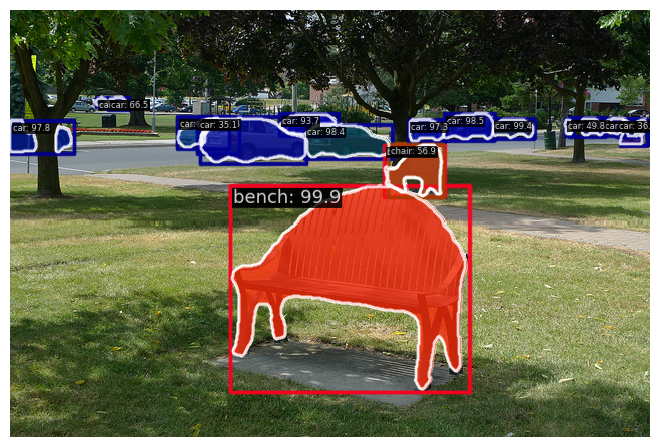

In [ ]:
# show the results
visualizer.add_datasample(
    'result',
    image,
    data_sample=result,
    draw_gt = None,
    wait_time=0,
)
visualizer.show()

## Train a Detector on A Customized Dataset

To train a new detector, there are usually three things to do:
1. Support a new dataset
2. Modify the config
3. Train a new detector



### Support a new dataset

There are three ways to support a new dataset in MMDetection:
  1. Reorganize the dataset into a COCO format
  2. Reorganize the dataset into a middle format
  3. Implement a new dataset

We recommend the first two methods, as they are usually easier than the third.

In this tutorial, we give an example that converts the data into COCO format because MMDetection **only support evaluating mask AP of dataset in COCO format for now**. Other methods and more advanced usages can be found in the [doc](https://mmdetection.readthedocs.io/en/latest/advanced_guides/customize_dataset.html).

First, let's download the [the balloon dataset](https://github.com/matterport/Mask_RCNN/tree/master/samples/balloon).

In [ ]:
# download and unzip the data
!wget -c https://github.com/matterport/Mask_RCNN/releases/download/v2.1/balloon_dataset.zip

In [ ]:
!unzip imaterialist-fashion-2019-FGVC6.zip -d ./data/

In [ ]:
! pwd

/content/drive/MyDrive/COMP4471/Project/mmdetection/data


# Check the directory structure of the tiny data

# Install tree first in your terminal(linux)
sudo apt-get -q install tree


In [ ]:
# ! sudo apt-get -q install tree

Reading package lists...
Building dependency tree...
Reading state information...
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 19 not upgraded.
Need to get 47.9 kB of archives.
After this operation, 116 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tree amd64 2.0.2-1 [47.9 kB]
Fetched 47.9 kB in 1s (82.5 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package tree.
(Reading database ... 120874 files and directories currently installed.)
Preparing

In [ ]:
# os.chdir('/content/drive/MyDrive/COMP4471/Project/mmdetection')
# os.chdir('/content/drive/MyDrive/Project/mmdetection')

In [ ]:
!tree data

In [6]:
! pwd

/Users/Chloe/Desktop/Uni/2023_Fall/COMP4471/project


In [2]:
# os.chdir('/content/drive/MyDrive/COMP4471/Project/mmdetection/data')
# os.chdir('/content/drive/MyDrive/Project/mmdetection/data')

In [2]:
os.chdir('./imaterialist')

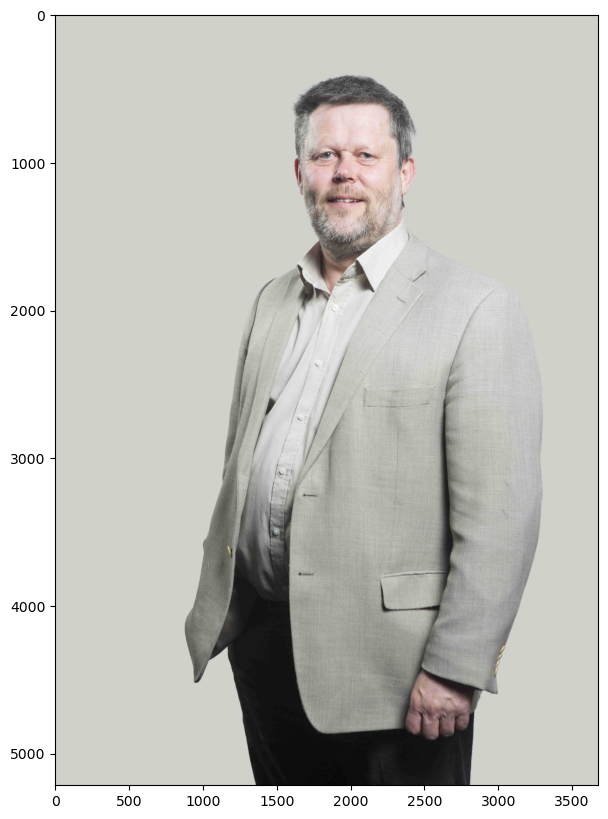

In [4]:
img = mmcv.imread('train/00000663ed1ff0c4e0132b9b9ac53f6e.jpg')
plt.figure(figsize=(15, 10))
plt.imshow(mmcv.bgr2rgb(img))
plt.show()

After downloading the data, we need to implement a function to convert the annotation format into the COCO format. Then we can use implemented `COCODataset` to load the data and perform training and evaluation.
Let's take a look at the annotation json file.



In [3]:
# Read the CSV file
train_df = pd.read_csv('train.csv', nrows=100)

# Convert DataFrame to JSON
# json_data = train_df.to_json('/content/drive/MyDrive/Project/mmdetection/data/annotation.json', orient='records')
# json_data = train_df.to_json('/content/drive/MyDrive/COMP4471/Project/mmdetection/data/annotation.json', orient='records')


# Print the JSON data
# annotation = mmengine.load('annotation.json')

In [11]:
train_df.head()

,ImageId,EncodedPixels,Height,Width,ClassId
0,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,6068157 7 6073371 20 6078584 34 6083797 48 608...,5214,3676,6
1,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,6323163 11 6328356 32 6333549 53 6338742 75 63...,5214,3676,0
2,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,8521389 10 8526585 30 8531789 42 8537002 46 85...,5214,3676,28
3,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,12903854 2 12909064 7 12914275 10 12919485 15 ...,5214,3676,31
4,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,10837337 5 10842542 14 10847746 24 10852951 33...,5214,3676,32


In [ ]:
uniq_images = train_df.ImageId.unique()
len(uniq_images)

6831

In [ ]:
print(len(train_df.Width.unique()))
print(len(train_df.Height.unique()))

16
15


In [4]:
# remove all the attributes after "_" in train_df['ClassId']
train_df['ClassId'] = train_df['ClassId'].str.split('_').str.get(0)

In [5]:
train_df['ImageId'] = pd.factorize(train_df['ImageId'])[0]
train_df.head()

,ImageId,EncodedPixels,Height,Width,ClassId
0,0,6068157 7 6073371 20 6078584 34 6083797 48 608...,5214,3676,6
1,0,6323163 11 6328356 32 6333549 53 6338742 75 63...,5214,3676,0
2,0,8521389 10 8526585 30 8531789 42 8537002 46 85...,5214,3676,28
3,0,12903854 2 12909064 7 12914275 10 12919485 15 ...,5214,3676,31
4,0,10837337 5 10842542 14 10847746 24 10852951 33...,5214,3676,32


In [ ]:
# json_data = train_df.to_json('/content/drive/MyDrive/COMP4471/Project/mmdetection/data/annotation.json', orient='records')
# annotation = mmengine.load('annotation.json')

In [8]:
from pycocotools import mask as maskUtils

def rle_decoding(encoding, height, width):
    """
    Decodes RLE encoding into a binary mask and calculates the masked area and bbox.

    Parameters:
        encoding (str): RLE encoding as a space-separated string.
        height (int): Height of the image.
        width (int): Width of the image.

    Returns:
        mask (1d array): Decoded binary mask with shape (height, width).
        area (float): Total number of pixels in the mask.
        bbox (list): Bounding box coordinates [x, y, width, height].

    """
    # Remove space
    encoding = encoding.split()

    encoding = list(map(int, encoding))

    generated_1d_mask = np.zeros(width*height)

    for j in range(len(encoding) // 2):
      generated_1d_mask[encoding[j * 2]:encoding[j * 2]+encoding[j * 2+1]] = 1

    mask = generated_1d_mask.reshape((width, height)).T.astype(int)
    area = float(np.sum(mask))

    # Find the coordinates of the foreground pixels
    coords = np.argwhere(mask == 1)

    # Calculate the bounding box
    x_min, y_min = np.min(coords, axis=0)
    x_max, y_max = np.max(coords, axis=0)
    bbox = [x_min, y_min, x_max - x_min + 1, y_max - y_min + 1]

    return mask, area, bbox

938874.0
[1372, 1212, 2608, 1183]


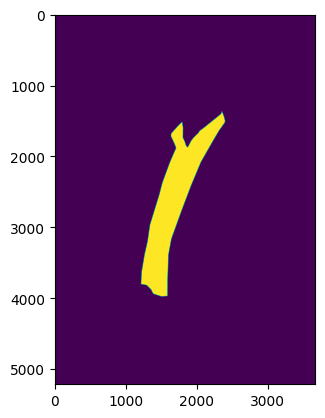

In [12]:
encoding = train_df.iloc[1]['EncodedPixels']
height = train_df.iloc[1]['Height']
width = train_df.iloc[1]['Width']

generated_mask, area, bbox = rle_decoding(encoding, height, width)
# mask = generated_mask.reshape((width, height)).T
print(area)
print(bbox)

plt.imshow(generated_mask)

In [15]:
# new_train_df = train_df.iloc[:10000].copy()

# Create empty lists for the new columns
segmentation_list = []
area_list = []
bbox_list = []

for i in range(len(train_df)):
    encoding = train_df.iloc[i]['EncodedPixels']
    height = train_df.iloc[i]['Height']
    width = train_df.iloc[i]['Width']
    mask, area, bbox = rle_decoding(encoding, height, width)

    # Append the values to the respective lists
    segmentation_list.append(mask)
    area_list.append(area)
    bbox_list.append(bbox)

# Assign the lists to the DataFrame columns
train_df['segmentation'] = segmentation_list
train_df['area'] = area_list
train_df['bbox'] = bbox_list

In [16]:
train_df['iscrowd'] = 0
train_df.drop('EncodedPixels', axis=1, inplace = True)
train_df.head()

,ImageId,Height,Width,ClassId,segmentation,area,bbox,iscrowd
0,0,5214,3676,6,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",883261.0,"[3924, 1163, 1290, 1677]",0
1,0,5214,3676,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",938874.0,"[1372, 1212, 2608, 1183]",0
2,0,5214,3676,28,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",90430.0,"[1372, 1634, 521, 761]",0
3,0,5214,3676,31,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1501168.0,"[1828, 2474, 2776, 836]",0
4,0,5214,3676,32,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",61632.0,"[2510, 2078, 154, 500]",0


In [19]:
!pwd

/Users/Chloe/Desktop/Uni/2023_Fall/COMP4471/project/imaterialist


In [22]:
# Define the file path for the JSON file
output_dir = '/Users/Chloe/Desktop/Uni/2023_Fall/COMP4471/project/imaterialist'
output_file = 'annotation.json'
output_path = os.path.join(output_dir, output_file)

# Convert DataFrame to JSON and save it
json_data = train_df.to_json(orient='records')
with open(output_path, 'w') as file:
    file.write(json_data)
# json_data = train_df.to_json('/content/drive/MyDrive/Project/mmdetection/data/annotation.json', orient='records')
# annotation = mmengine.load('annotation.json')
# pprint(annotation)

[{'ClassId': '6',
  'Height': 5214,
  'ImageId': 0,
  'Width': 3676,
  'area': 883261.0,
  'bbox': [3924, 1163, 1290, 1677],
  'iscrowd': 0,
  'segmentation': 

In [ ]:
# annotation = mmengine.load('/Users/Chloe/Desktop/Uni/2023_Fall/COMP4471/project/imaterialist/annotation.json')
# pprint(annotation[0])

In [6]:
coco_base = { "info": {},
              "images": [],
              "annotations": [],
              "categories": []}

In [7]:
coco_base["info"] = {
    "year": 2019,
    "version": "1.0",
    "description": "The 2019 FGVC^6 iMaterialist Competition - Fashion track dataset.",
    "contributor": "iMaterialist Fashion Competition group",
    "url": "https://github.com/visipedia/imat_comp",
    "date_created": "2019-04-19 12:38:27.493919"
}

In [10]:

category_json = mmengine.load('/Users/Chloe/Desktop/Uni/2023_Fall/COMP4471/project/imaterialist/label_descriptions.json')
# print('0')

In [11]:
coco_base["categories"] = [
    {
        "id": category["id"],
        "name": category["name"],
        "supercategory": category["supercategory"]
    }
    for category in category_json["categories"]
]

In [12]:
import json
# Print the updated coco_base
print(json.dumps(coco_base, indent=4))

{
    "info": {
        "year": 2019,
        "version": "1.0",
        "description": "The 2019 FGVC^6 iMaterialist Competition - Fashion track dataset.",
        "contributor": "iMaterialist Fashion Competition group",
        "url": "https://github.com/visipedia/imat_comp",
        "date_created": "2019-04-19 12:38:27.493919"
    },
    "images": [],
    "annotations": [],
    "categories": [
        {
            "id": 0,
            "name": "shirt, blouse",
            "supercategory": "upperbody"
        },
        {
            "id": 1,
            "name": "top, t-shirt, sweatshirt",
            "supercategory": "upperbody"
        },
        {
            "id": 2,
            "name": "sweater",
            "supercategory": "upperbody"
        },
        {
            "id": 3,
            "name": "cardigan",
            "supercategory": "upperbody"
        },
        {
            "id": 4,
            "name": "jacket",
            "supercategory": "upperbody"
        },
        

According to the above observation, each single image has a corresponding annotation containing keys `filename` and `regions` that are necessary for training.
We need to read annotations of each image and convert them into COCO format as below:

```python
{
    "images": [image],
    "annotations": [annotation],
    "categories": [category]
}


image = {
    "id": int,
    "width": int,
    "height": int,
    "file_name": str,
}

annotation = {
    "id": int,
    "image_id": int,
    "category_id": int,
    "segmentation": RLE or [polygon],
    "area": float,
    "bbox": [x,y,width,height],
    "iscrowd": 0 or 1,
}

categories = [{
    "id": int,
    "name": str,
    "supercategory": str,
}]
```
**Note**: We only list the necessary keys for training, as shown above. For a full COCO format, please see [here](https://cocodataset.org/#format-data).

In [ ]:
import os.path as osp

def convert_balloon_to_coco(ann_file, out_file, image_prefix):
    data_infos = mmengine.load(ann_file)

    annotations = []
    images = []
    obj_count = 0
    for idx, v in enumerate(mmengine.track_iter_progress(data_infos.values())):
        filename = v['filename']
        img_path = osp.join(image_prefix, filename)
        height, width = mmcv.imread(img_path).shape[:2]

        images.append(dict(
            id=idx,
            file_name=filename,
            height=height,
            width=width))

        bboxes = []
        labels = []
        masks = []
        for _, obj in v['regions'].items():
            assert not obj['region_attributes']
            obj = obj['shape_attributes']
            px = obj['all_points_x']
            py = obj['all_points_y']
            poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]

            x_min, y_min, x_max, y_max = (
                min(px), min(py), max(px), max(py))


            data_anno = dict(
                image_id=idx,
                id=obj_count,
                category_id=0,
                bbox=[x_min, y_min, x_max - x_min, y_max - y_min],
                area=(x_max - x_min) * (y_max - y_min),
                segmentation=[poly],
                iscrowd=0)
            annotations.append(data_anno)
            obj_count += 1

    coco_format_json = dict(
        images=images,
        annotations=annotations,
        categories=[{'id':0, 'name': 'balloon'}])
    mmengine.dump(coco_format_json, out_file)

In [ ]:
convert_balloon_to_coco(
    './ballondatasets/balloon/train/via_region_data.json',
    './ballondatasets/balloon/train/annotation_coco.json',
    './ballondatasets/balloon/train/')
convert_balloon_to_coco(
    './ballondatasets/balloon/val/via_region_data.json',
    './ballondatasets/balloon/val/annotation_coco.json',
    './ballondatasets/balloon/val/')

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 61/61, 19.7 task/s, elapsed: 3s, ETA:     0s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 13/13, 20.1 task/s, elapsed: 1s, ETA:     0s


Checking the label corresponding to the instance split ID after the data format conversion is complete

In [ ]:
from pycocotools.coco import COCO

# Path to load the COCO annotation file
annotation_file = './ballondatasets/balloon/train/annotation_coco.json'

# Initialise the COCO object
coco = COCO(annotation_file)

# Get all category tags and corresponding category IDs
categories = coco.loadCats(coco.getCatIds())
category_id_to_name = {cat['id']: cat['name'] for cat in categories}

# Print all category IDs and corresponding category names
for category_id, category_name in category_id_to_name.items():
    print(f"Category ID: {category_id}, Category Name: {category_name}")

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Category ID: 0, Category Name: balloon


### Modify the config

In the next step, we need to modify the config for the training.
To accelerate the process, we finetune a detector using a pre-trained detector.

In [ ]:
from mmengine import Config
cfg = Config.fromfile('./configs/mask_rcnn/mask-rcnn_r50-caffe_fpn_ms-poly-1x_coco.py')

Given a config that trains a Mask R-CNN on COCO dataset, we need to modify some values to use it for training on the balloon dataset.

In [ ]:
from mmengine.runner import set_random_seed

# Modify dataset classes and color
cfg.metainfo = {
    'classes': ('balloon', ),
    'palette': [
        (220, 20, 60),
    ]
}

# Modify dataset type and path
cfg.data_root = './ballondatasets/balloon'

cfg.train_dataloader.dataset.ann_file = 'train/annotation_coco.json'
cfg.train_dataloader.dataset.data_root = cfg.data_root
cfg.train_dataloader.dataset.data_prefix.img = 'train/'
cfg.train_dataloader.dataset.metainfo = cfg.metainfo

cfg.val_dataloader.dataset.ann_file = 'val/annotation_coco.json'
cfg.val_dataloader.dataset.data_root = cfg.data_root
cfg.val_dataloader.dataset.data_prefix.img = 'val/'
cfg.val_dataloader.dataset.metainfo = cfg.metainfo

cfg.test_dataloader = cfg.val_dataloader

# Modify metric config
cfg.val_evaluator.ann_file = cfg.data_root+'/'+'val/annotation_coco.json'
cfg.test_evaluator = cfg.val_evaluator

# Modify num classes of the model in box head and mask head
cfg.model.roi_head.bbox_head.num_classes = 1
cfg.model.roi_head.mask_head.num_classes = 1

# We can still the pre-trained Mask RCNN model to obtain a higher performance
cfg.load_from = 'checkpoints/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth'

# Set up working dir to save files and logs.
cfg.work_dir = './tutorial_exps'


# We can set the evaluation interval to reduce the evaluation times
cfg.train_cfg.val_interval = 3
# We can set the checkpoint saving interval to reduce the storage cost
cfg.default_hooks.checkpoint.interval = 3

# The original learning rate (LR) is set for 8-GPU training.
# We divide it by 8 since we only use one GPU.
cfg.optim_wrapper.optimizer.lr = 0.02 / 8
cfg.default_hooks.logger.interval = 10


# Set seed thus the results are more reproducible
# cfg.seed = 0
set_random_seed(0, deterministic=False)

# We can also use tensorboard to log the training process
cfg.visualizer.vis_backends.append({"type":'TensorboardVisBackend'})

#------------------------------------------------------
config=f'./configs/mask_rcnn/mask-rcnn_r50-caffe_fpn_ms-poly-3x_balloon.py'
with open(config, 'w') as f:
    f.write(cfg.pretty_text)

### Train a new detector

Finally, lets initialize the dataset and detector, then train a new detector!

In [ ]:
!python tools/train.py {config}

08/15 04:31:57 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.10.12 (main, Jun 11 2023, 05:26:28) [GCC 11.4.0]
    CUDA available: True
    numpy_random_seed: 1186080067
    GPU 0: Tesla T4
    CUDA_HOME: /usr/local/cuda
    NVCC: Cuda compilation tools, release 11.8, V11.8.89
    GCC: x86_64-linux-gnu-gcc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0
    PyTorch: 2.0.1+cu118
    PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201703
  - Intel(R) oneAPI Math Kernel Library Version 2022.2-Product Build 20220804 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.7.3 (Git Hash 6dbeffbae1f23cbbeae17adb7b5b13f1f37c080e)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 11.8
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=compute_5

### Understand the log
From the log, we can have a basic understanding on the training process and know how well the detector is trained.

First, since the dataset we are using is small, we loaded a Mask R-CNN model and finetune it for detection. Because the original Mask R-CNN is trained on COCO dataset that contains 80 classes but KITTI Tiny dataset only have 3 classes. Therefore, the last FC layers of the pre-trained Mask R-CNN for classification and regression have different weight shape and are not used. The pre-trained weights of mask prediction layer `mask_head.conv_logits` also does not matches the current model and is not used due to similar reason.

Third, after training, the detector is evaluated by the default COCO-style evaluation. The results show that the detector achieves 79.6 bbox AP and 81.5 mask AP on the val dataset, not bad!

 We can also check the tensorboard to see the curves.

In [ ]:
%pip install tensorboard  -i https://mirrors.ustc.edu.cn/pypi/web/simple

In [ ]:
# load tensorboard in jupyter notebook
%load_ext tensorboard

In [ ]:
# see curves in tensorboard
# if you see <IPython.core.display.HTML object> please run it again
%tensorboard --logdir tutorial_exps/

## Test the Trained Detector

After finetuning the detector, let's visualize the prediction results!

In [ ]:
import mmcv
from mmdet.apis import init_detector, inference_detector
img = mmcv.imread('./ballondatasets/balloon/train/7178882742_f090f3ce56_k.jpg',channel_order='rgb')
checkpoint_file = 'tutorial_exps/epoch_12.pth'
model = init_detector(cfg, checkpoint_file, device='cpu')
new_result = inference_detector(model, img)
print(new_result)

Loads checkpoint by local backend from path: tutorial_exps/epoch_12.pth
<DetDataSample(

    META INFORMATION
    batch_input_shape: (800, 1216)
    pad_shape: (800, 1216)
    scale_factor: (0.58837890625, 0.5882352941176471)
    img_id: 0
    ori_shape: (1360, 2048)
    img_shape: (800, 1205)
    img_path: None

    DATA FIELDS
    gt_instances: <InstanceData(
        
            META INFORMATION
        
            DATA FIELDS
            labels: tensor([], dtype=torch.int64)
            bboxes: tensor([], size=(0, 4))
            masks: BitmapMasks(num_masks=0, height=1360, width=2048)
        ) at 0x79a3a96e32b0>
    ignored_instances: <InstanceData(
        
            META INFORMATION
        
            DATA FIELDS
            labels: tensor([], dtype=torch.int64)
            bboxes: tensor([], size=(0, 4))
            masks: BitmapMasks(num_masks=0, height=1360, width=2048)
        ) at 0x79a3a96e2e90>
    pred_instances: <InstanceData(
        
            META INFORMATION

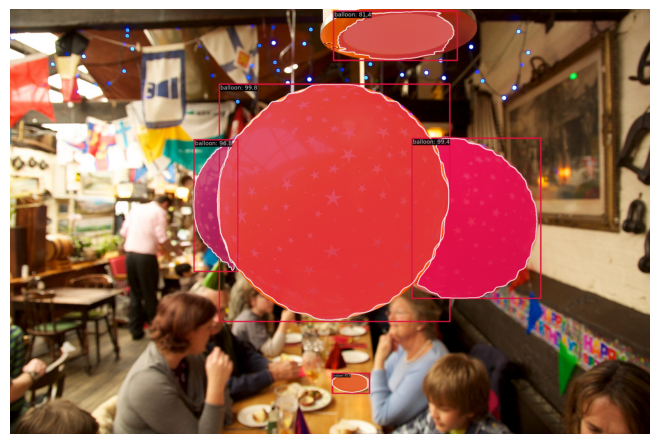

In [ ]:
from mmengine.visualization import Visualizer
# get built visualizer
visualizer_now = Visualizer.get_current_instance()
# the dataset_meta is loaded from the checkpoint and
# then pass to the model in init_detector
visualizer_now.dataset_meta = model.dataset_meta
# show the results
visualizer_now.add_datasample(
    'new_result',
    img,
    data_sample=new_result,
    draw_gt=False,
    wait_time=0,
    out_file=None,
    pred_score_thr=0.5
)
visualizer_now.show()

## What to Do Next?

So far, we have learnt how to test and train Mask R-CNN. To further explore the segmentation task, you could do several other things as shown below:

- Try cascade methods, e.g., [Cascade Mask R-CNN](https://github.com/open-mmlab/mmdetection/tree/master/configs/cascade_rcnn) and [HTC](https://github.com/open-mmlab/mmdetection/tree/master/configs/htc) in [MMDetection model zoo](https://github.com/open-mmlab/mmdetection/blob/master/docs/en/model_zoo.md). They are powerful detectors that are ranked high in many benchmarks, e.g., COCO dataset.
- Try single-stage methods, e.g., [K-Net](https://github.com/ZwwWayne/K-Net) and [Dense-RepPoints](https://github.com/justimyhxu/Dense-RepPoints). These two algorithms are based on MMDetection. Box-free instance segmentation is a new trend in the instance segmentation community.
- Try semantic segmentation. Semantic segmentation is also a popular task with wide applications. You can explore [MMSegmentation](https://github.com/open-mmlab/mmsegmentation/); we also provide a [colab tutorial](https://github.com/open-mmlab/mmsegmentation/blob/master/demo/MMSegmentation_Tutorial.ipynb) for semantic segmentation using MMSegmentation.
